In [1]:
from os.path import isfile, join, exists
from os import listdir, makedirs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from brainpipe.system import study
from scipy import stats
from itertools import product

### Plot correlation btw power and score in signif elecs // normalized by subject

In [60]:
from mne.stats import bonferroni_correction, fdr_correction

feat, corr, phase, win, th, alpha = 'pow', False, 'Retrieval', 1.0, '0.01',0.05
#feat, corr, phase, win, th, alpha = 'pow', False, 'TPSim', 1,'0.01',0.05
###############################################################################
st = study('Olfacto')
path_npz = join(st.path, 'feature/0_Power_'+phase+'_By_Odor/')
npz_form = join(path_npz, '{}_odor_{}_bipo_sel_physFT_pow.npz')
path_classif = join(st.path, 'figure/0_Classif_Power_'+phase[0]+'_EpiPerf_LowHigh_1000perm_BBG/')
classif_npz = join(path_classif, '{}_sources_{}_{}_low_high_sel_physFT.npz')
masks_form = join(path_classif, 'masks_stat/All_subjects_mask_stat_{}_minwin{}_th{}.npy') 
path2save = join(st.path, 'correlations_pow_all_trials/'+phase+'/'+phase.lower()+'_signif_elecs/')
f_form_save = join(path2save, 'Correl_{}_{}_{}_{}.png')
###############################################################################
#path_classif = join(st.path, 'figure/LDA_TPSim_E_R_all_BBG/')
#classif_npz = join(path_classif, '{}_sources_{}_{}_low_high_sel_physFT.npz')
#masks_form = join(path_classif, 'masks_stat/All_subjects_mask_stat_{}_minwin{}_th{}.npy') 
#path_npz = join(st.path, 'feature/TPSim_Enc_Ret_By_Odor_all/TPS_R_p_by_odor/')
#npz_form = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
#path2save = join(st.path, 'correlations_pow_all_trials/'+phase+'/'+phase.lower()+'_signif_elecs/')
#path2save = join(st.path, 'correlations_pow_all_trials/TPS_all_elecs/TPS_signif_elecs/')
#f_form_save = join(path2save, 'Correl_{}_{}_{}_{}.png')

su_codes = [['S0','S1','S2','S3','S4','S5','S6'] if phase == 'Encoding' else ['S0','S1','S2','S3','S4','S5']]
#freqs = ['2_theta', '3_alpha', '4_beta','5_gamma1','6_gamma2']
freqs = ['0_theta', '1_alpha', '2_beta','3_gamma']
method = ['s_Mail_RL']
###############################################################################

if phase == 'Encoding':
    odors_su = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'MICP': {2:6,12:8,6:96,8:8,3:12,18:4,9:6,14:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}
else:
    odors_su = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #15:4 remove for TPS
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}

u_color = ["darkblue", "royalblue", "deepskyblue", "mediumspringgreen", "yellow", "darkorange","red"]
rois_to_keep = ['ACC','Amg','Amg-PirT','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']
rois = ['ACC','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']
                
pvals, pvals2, R_all, roi_val = [], [], [], []
for i,freq in enumerate(freqs):
    #Load all data classif 
    mat = np.load(classif_npz.format('All_subjects',freq, 'odor'))
    #Filter matrix for MTl, Olf and Frontal regions
    id_rois = np.where([roi in rois_to_keep for roi in mat['s_labels']])
    subjects = mat['su_codes'][id_rois]
    #Load mask for significant elecs
    mask = np.load(masks_form.format(freq,str(win),th))
    mask = np.logical_not(mask) #transform inverse of visbrain 
    
    #Correlation by freq and by region for all subjects
    for region in sorted(rois):
        pow_odors,pow_raw, scores_odors, su_list = [], [], [],[]
        for s,su in enumerate(sorted(odors_su)):
            mask_su = mask[np.where(subjects=='S'+str(s))]
            pow_su, score_su = [], []
            for odor in odors_su[su]:
                arch_sig = np.load(npz_form.format(su,odor,freq))
                id_roi_su = np.where([roi in rois_to_keep for roi in arch_sig['Mai_RL']])
                #print(arch_sig['label'], id_roi_su)
                Mai_RL= arch_sig['Mai_RL'][id_roi_su][mask_su] #'Mai_RL'
                #print(su, arch_sig['xpow'].shape)
                #print(len(id_roi_su[0]))
                #print(Mai_RL.shape, arch_sig['xpow'].shape)
                power = np.mean(arch_sig['xpow'][i,:,27:47,:],axis=(1))[id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                #power = arch_sig['xpow'][i,:,20,:][mask_su] #rest

                #power = arch_sig['tps'][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                if region == 'pPirT':
                    power_roi = power[[roi in ['pPirT','Amg','Amg-PirT'] for roi in Mai_RL]]
                else:
                    power_roi = power[np.where(Mai_RL==region)]
                power_roi = np.ndarray.flatten(power_roi)
                score_roi = [odors_su[su][odor]]*power_roi.shape[0]
                su_codes = ['S'+str(s)]*power_roi.shape[0]
                pow_su = np.append(pow_su,power_roi)
                score_su = np.append(score_su,score_roi)
                su_list = np.append(su_list,su_codes)
            pow_su = (pow_su - pow_su.mean())/pow_su.std()
            score_su = (score_su - score_su.mean())/score_su.std()
            pow_odors = np.append(pow_odors,pow_su)
            scores_odors = np.append(scores_odors,score_su)
        scores_odors = np.array(scores_odors)[np.where(~np.isnan(pow_odors))]
        pow_odors = np.array(pow_odors)[np.logical_not(np.isnan(pow_odors))]
        print(region,len(scores_odors),len(pow_odors))
        #Plot all correlations
        R, p = stats.pearsonr(scores_odors,pow_odors)
        R2, p2 = stats.spearmanr(scores_odors,pow_odors)
        R, p = round(R,2), round(p,7)
        R2, p2 = round(R2,2), round(p2,7)
        pvals, pvals2 = np.append(pvals,p), np.append(pvals2,p2)
        roi_val = np.append(roi_val,region)
        R_all = np.append(R_all, R2)
        print('stats for',freq,region,R,p,R2,p2)
        color = [u_color[int(k[1])] for k in sorted(su_list)]
        if np.size(pow_odors):
            fig, ax = plt.subplots()
            plt.title('Epi score and '+freq+' power in '+region+' // npoints ='+str(len(scores_odors)))
            plt.xlabel('EpiScore'), plt.ylabel(freq)
            anchored_text = AnchoredText('R2 = %s, p2 = %s' % (R2, p2), loc=2) if p2 < (0.05/20) else AnchoredText('R = %s, p = %s' % (R, p), loc=2)
            ax.add_artist(anchored_text)
            fit = np.polyfit(scores_odors, pow_odors, deg=1)
            ax.plot(sorted(scores_odors), fit[0] * np.array(sorted(scores_odors)) + fit[1], color='red')
            ax.scatter(scores_odors, pow_odors, color = color)
            plt.savefig(f_form_save.format(freq,region,'EpiScore_win1','z-score'))
            plt.clf()
            plt.close()
#pvals2 = pvals2[roi_val=='HC']
#R_all = R_all[roi_val=='HC']
#pvals = np.array(pvals)[np.logical_not(np.isnan(pvals))]
roi_val = np.array(roi_val)[np.logical_not(np.isnan(pvals2))]
R_all = np.array(R_all)[np.logical_not(np.isnan(pvals2))]
pvals2 = np.array(pvals2)[np.logical_not(np.isnan(pvals2))]

## Determine the threshold p value for FDR correction
# _, pval_bonf = bonferroni_correction(pvals, alpha=alpha)
# print(np.round(pval_bonf,3))
_, pval_bonf2 = bonferroni_correction(pvals2, alpha=alpha)
print(pval_bonf2[roi_val=='pPirT'])

# _, pval_fdr = fdr_correction(pvals, alpha=alpha, method='indep')
# print(np.round(pval_fdr,3))
_, pval_fdr2 = fdr_correction(pvals2, alpha=0.01, method='indep')
print(np.round(pval_fdr2[roi_val=='pPirT'],3))
print(R_all[roi_val=='pPirT'])

-> Olfacto loaded
ACC 48 48
stats for 0_theta ACC -0.02 0.8820273 0.03 0.856826


/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice.
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of e

HC 152 152
stats for 0_theta HC -0.06 0.4420089 -0.09 0.2605175
IFG 264 264
stats for 0_theta IFG 0.09 0.1516301 0.07 0.2815998
Ins 124 124
stats for 0_theta Ins 0.1 0.2534649 0.11 0.2177667
MFG 144 144
stats for 0_theta MFG -0.03 0.7201057 0.03 0.7162548
OFC 120 120
stats for 0_theta OFC 0.17 0.0642284 0.2 0.0247454
PHG 72 72
stats for 0_theta PHG 0.08 0.5251467 0.05 0.6636917
SFG 336 336
stats for 0_theta SFG 0.08 0.1501688 0.05 0.3954907
pPirT 24 24
stats for 0_theta pPirT 0.34 0.1046467 0.34 0.102245
ACC 72 72
stats for 1_alpha ACC 0.07 0.5595196 0.07 0.5873226
HC 156 156
stats for 1_alpha HC 0.05 0.5446906 0.05 0.5551438
IFG 196 196
stats for 1_alpha IFG -0.11 0.1298104 -0.1 0.1515599
Ins 172 172
stats for 1_alpha Ins 0.18 0.015321 0.11 0.1493161
MFG 120 120
stats for 1_alpha MFG 0.05 0.5830788 0.07 0.4634387
OFC 128 128
stats for 1_alpha OFC -0.12 0.1852279 -0.04 0.6209535
PHG 96 96
stats for 1_alpha PHG 0.12 0.2596138 0.09 0.4033306
SFG 312 312
stats for 1_alpha SFG -0.06 0.3001

/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/scipy/stats/stats.py:3016: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/scipy/stats/stats.py:3017: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [68]:
roi = 'ACC'
_, pval_fdr2 = fdr_correction(pvals2, alpha=0.01, method='indep')
print(np.round(pval_fdr2[roi_val==roi],3))
print(R_all[roi_val==roi])

[ 0.962  0.821  0.007  0.81 ]
[ 0.03  0.07  0.51  0.13]


### Correlation btw power and TR at retrieval

In [ ]:
## CREATE DICTIONARY OF TR AND ODORS BY SUBJECTS
import pandas as pd

PATH = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/1bis_OE_BaseSam/JPlailly201306_seeg_ALS/behavior/'
odors_su = ['VACJ','SEMC','PIRJ','FERJ','LEFC','CHAF']
scores = ['odor_recognition_rt','episodic_rt','diff']

for score in scores:
    dict = {}
    for su in odors_su:
        df = pd.read_excel(PATH+'episodic_individual_results_.xls',sheetname=su)
        df = df[['odor_num','trial_recognition','is_target','odor_recognition_rt',
                 'score_episodic_strict','episodic_rt']]
        df = df.loc[df.is_target==1]
        df['diff'] = df['episodic_rt'] - df['odor_recognition_rt']
#         if score == 'odor_recognition_rt':
#             df = df.loc[df['score_episodic_strict'].isin(['What-S1','WWhich-S1','WWhere-S1','WWW-S1'])]
#         if score == 'episodic_rt':
#             df = df.loc[df['score_episodic_strict'].isin(['WWhich-S1','WWhere-S1','WWW-S1'])]
#         if score == 'diff':
#             df = df.loc[df['score_episodic_strict'].isin(['WWhich-S1','WWhere-S1','WWW-S1'])]
        df2 = df[['odor_num',score]] 
        df2 = df2[df2[score] > 0].groupby(['odor_num']).mean() 
        su_dict = {}
        for index,row in df2.iterrows():
            su_dict[index] = float('{:.2f}'.format(round(row.values[0],2)))
        dict[su] = su_dict
    print(score,dict)


In [9]:
from mne.stats import bonferroni_correction, fdr_correction

scoring = 'dqio'
feat, corr, win, th, phase = 'pow', False, 1.0, '0.01','Encoding'
###############################################################################
st = study('Olfacto')
#path_npz = join(st.path, 'feature/0_Power_'+phase+'_By_Odor/')
#npz_form = join(path_npz, '{}_odor_{}_bipo_sel_physFT_pow.npz')
#path_classif = join(st.path, 'figure/0_Classif_Power_'+phase[0]+'_EpiPerf_LowHigh_1000perm_BBG/')
path_npz = join(st.path, 'feature/TPSim_Enc_Ret_By_Odor_all/TPS_R_p_by_odor/')
npz_form = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
path_classif = join(st.path, 'figure/LDA_TPSim_E_R_all_BBG/')
# path_classif = join(st.path, 'figure/LDA_Power_R_pre_stim_1s_BBG/')
classif_npz = join(path_classif, '{}_sources_{}_{}_low_high_sel_physFT.npz')
masks_form = join(path_classif, 'masks_stat/All_subjects_mask_stat_{}_minwin{}_th{}.npy') 
path2save = join(st.path, 'correlations_pow_all_trials/TPS_all_elecs/TPS_all_elecs_signif/')
#path2save = join(st.path, 'correlations_pow_all_trials/'+phase+'/TR_'+phase[0]+'_signif_'+scoring.lower()+'/')
f_form_save = join(path2save, 'Correl_{}_{}_{}_{}_first.png')
f_form_save2 = join(path2save, 'Correl_{}_{}_{}_{}_first.pdf')
###############################################################################
#freqs = ['2_theta', '3_alpha', '4_beta','5_gamma1','6_gamma2']
freqs = ['0_theta','1_alpha','2_beta','3_gamma']
method = ['label']
###############################################################################
sub_list = ['VACJ','SEMC','PIRJ','FERJ','LEFC','CHAF','MICP'] if phase == 'Encoding' else ['VACJ','SEMC','PIRJ','FERJ','LEFC','CHAF']
if scoring == 'Rec':
    odors_su = { 'LEFC': {16: 4.68, 1: 3.94, 2: 8.43, 3: 6.05, 4: 4.74, 17: 5.52, 14: 4.03, 15: 5.01}, 
                 'SEMC': {5: 9.1, 7: 6.08, 8: 9.11, 9: 6.62, 10: 7.76, 11: 8.53, 12: 9.99, 13: 4.17}, 
                 'PIRJ': {1: 4.48, 18: 5.89, 4: 5.75, 5: 7.43, 6: 5.11, 7: 3.14, 9: 5.79}, 
                 'FERJ': {16: 5.0, 1: 2.28, 2: 4.14, 17: 4.12, 5: 3.08, 7: 2.8, 12: 3.11, 13: 3.53}, 
                 'CHAF': {1: 3.21, 2: 6.7, 3: 4.89, 4: 4.34, 5: 5.84, 7: 4.67, 8: 4.45, 9: 5.94}, 
                 'VACJ': {16: 5.86, 17: 10.84, 10: 7.37, 11: 10.04, 12: 10.65, 13: 4.56, 14: 9.16, 15: 6.45}}
    
if scoring == 'Epi':
    odors_su = {'LEFC': {16: 4.92, 1: 6.82, 3: 8.02, 4: 8.41, 17: 6.79, 14: 5.35, 15: 12.41}, 
                'SEMC': {5: 10.05, 7: 6.35, 8: 10.26, 9: 7.83, 10: 8.51, 11: 13.0, 12: 9.93, 13: 5.48}, 
                'PIRJ': {1: 4.81, 18: 8.11, 4: 9.33, 5: 9.83, 6: 10.57, 7: 4.98, 9: 7.54}, 
                'FERJ': {16: 7.96, 1: 4.42, 2: 5.89, 17: 6.3, 5: 4.84, 7: 5.23, 12: 4.33, 13: 7.07}, 
                'CHAF': {1: 4.39, 2: 9.27, 3: 6.42, 4: 6.26, 5: 7.96, 7: 5.82, 8: 6.08, 9: 7.77}, 
                'VACJ': {16: 8.25, 17: 15.96, 10: 14.97, 11: 14.79, 12: 25.83, 13: 10.68, 14: 16.55, 15: 6.1}}

if scoring == 'Diff':
    odors_su = {'LEFC': {16: 0.91, 1: 0.96, 3: 1.98, 4: 3.67, 17: 1.26, 14: 1.32, 15: 8.25}, 
                'SEMC': {5: 0.94, 7: 1.3, 8: 1.15, 9: 1.21, 10: 0.94, 11: 1.68, 12: 1.8, 13: 1.31}, 
                'PIRJ': {1: 1.15, 18: 1.85, 4: 3.61, 5: 3.78, 6: 5.78, 7: 2.69, 9: 3.12}, 
                'FERJ': {16: 2.16, 1: 2.14, 2: 2.51, 17: 2.28, 5: 1.76, 7: 2.43, 12: 1.73, 13: 3.54}, 
                'CHAF': {1: 1.18, 2: 1.71, 3: 1.53, 4: 1.92, 5: 2.12, 7: 1.16, 8: 1.63, 9: 1.84}, 
                'VACJ': {16: 2.39, 17: 7.42, 10: 7.6, 11: 3.87, 12: 15.17, 13: 6.12, 14: 7.38, 15: 2.46}}
else:
    odors_su = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #15:4 remove for TPS
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}
u_color = ["darkblue", "royalblue", "deepskyblue", "mediumspringgreen", "yellow", "darkorange","red"]
rois_to_keep = ['ACC','Amg','Amg-PirT','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']
rois_list = ['ACC','Amg','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']

pvals, pvals2, R_all, R2_all, rois_all, freqs_all = [], [], [], [], [], []
for i,freq in enumerate(freqs):
    mat = np.load(classif_npz.format('All_subjects',freq, 'odor'))
    print(mat.files)
    id_rois = np.where([roi in rois_to_keep for roi in mat['s_labels']]) #s_labels
    subjects = mat['su_codes'][id_rois]
    mask = np.load(masks_form.format(freq,str(win),th))
    mask = np.logical_not(mask) #inverse of visbrain 
    for roi in sorted(rois_list):
        if roi not in ['ACC','IFG','Ins','MFG','OFC','PHG','SFG']:
            pow_odors, scores_odors, su_list = [], [], []
            for s,su in enumerate(sorted(sub_list)):
                if phase == 'Encoding' and su =='MICP':
                    print('pass',su)
                else:
                    mask_su = mask[np.where(subjects=='S'+str(s))]
                    pow_su, score_su = [], []
                    for odor in odors_su[su]:
                        arch_sig = np.load(npz_form.format(su,odor,freq))
                        #print(arch_sig.files)
                        id_roi_su = np.where([roi in rois_to_keep for roi in arch_sig['label']])
                        Mai_RL= arch_sig['label'][id_roi_su][mask_su] #'Mai_RL', label
                        #print(Mai_RL.shape, arch_sig['xpow'].shape)
                        #power = np.mean(arch_sig['xpow'][i,:,27:47,:],axis=(1))[id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                        power = arch_sig['tps'][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                        if roi == 'pPirT' and power.size:
                            power_roi = power[np.where(roi in ['pPirT','Amg-PirT'] for roi in Mai_RL)]
                        else:
                            power_roi = power[np.where(Mai_RL==roi)]
                        power_roi = np.ndarray.flatten(power_roi)
                        su_list = np.append(su_list,su_codes)
#                         power_roi = np.mean(power_roi)[np.newaxis]
                        power_roi = power_roi[0][np.newaxis] if np.size(power_roi) else power_roi
                        score_roi = [odors_su[su][odor]]*power_roi.shape[0]
                        su_codes = ['S'+str(s)]*power_roi.shape[0]
                        pow_su = np.append(pow_su,power_roi)
                        score_su = np.append(score_su,score_roi)
                    pow_su = (pow_su - pow_su.mean())/pow_su.std()
                    score_su = (score_su - score_su.mean())/score_su.std()
                    pow_odors = np.append(pow_odors,pow_su)
                    scores_odors = np.append(scores_odors,score_su)
            scores_odors = np.array(scores_odors)[np.where(~np.isnan(pow_odors))]
            pow_odors = np.array(pow_odors)[np.logical_not(np.isnan(pow_odors))]
            print(roi,len(scores_odors),len(pow_odors))
            #Plot all correlations
            R, p = stats.pearsonr(scores_odors,pow_odors)
            R2, p2 = stats.spearmanr(scores_odors,pow_odors)
            R, p = round(R,2), round(p,7)
            R2, p2 = round(R2,2), round(p2,7)
            pvals, pvals2 = np.append(pvals,p), np.append(pvals2,p2)
            R_all = np.append(R_all, R)
            R2_all = np.append(R2_all, R2)
            print('stats for',freq,roi,R,p,R2,p2)
            rois_all.append(roi)
            freqs_all.append(freq)
            color = [u_color[int(k[1])] for k in sorted(su_list)]
            print('there are',len(np.unique(np.asarray(su_list))),'included in the analysis' )
            if p2 <= 0.06 or p <=0.06 and len(np.unique(np.asarray(su_list)))>2:
    #         if roi == 'HC':
                fig, ax = plt.subplots(figsize=(5,15))
                plt.title('Epi score and '+freq+' power in '+roi+' // npoints ='+str(len(scores_odors)))
                plt.xlabel('TR(s)'), plt.ylabel(freq)
                plt.ylim(-2,2)
                anchored_text = AnchoredText('R2 = %s, p2 = %s' % (R, p), loc=2)
                ax.add_artist(anchored_text)
                fit = np.polyfit(scores_odors, pow_odors, deg=1)
                ax.plot(sorted(scores_odors), fit[0] * np.array(sorted(scores_odors)) + fit[1], color='red')
                ax.scatter(scores_odors, pow_odors, color = color)
                plt.savefig(f_form_save.format(freq,roi,'EpiScore_win1','z-score'))
                plt.savefig(f_form_save2.format(freq,roi,'EpiScore_win1','z-score'))
                plt.clf()
                plt.close()
pvals = np.array(pvals)[np.logical_not(np.isnan(pvals))]
R2_all = np.array(R2_all)[np.logical_not(np.isnan(pvals2))]
rois_all = np.array(rois_all)[np.logical_not(np.isnan(pvals2))]
freqs_all = np.array(freqs_all)[np.logical_not(np.isnan(pvals2))]
pvals2 = np.array(pvals2)[np.logical_not(np.isnan(pvals2))]

## Determine the threshold p value for FDR correction
print(sorted(rois_list))
print('Spearman results')
print('R coef',R2_all)
_, pval_fdr2 = fdr_correction(pvals2, alpha=0.01, method='indep')
_, pval_fdr = fdr_correction(pvals, alpha=0.01, method='indep')

for i,s in enumerate(pval_fdr2):
#     if s < 0.05 :
    if rois_all[i] in ['HC','pPirT']: #'OFC','PHG',
        print(scoring,'FDR','freq',freqs_all[i],rois_all[i],'R',R2_all[i],'p',round(s,5))
        print(scoring,'FDR','freq',freqs_all[i],rois_all[i],'R',R_all[i],'p',round(pval_fdr[i],5))


-> Olfacto loaded
['s_elec', 's_da', 's_xyz', 's_elec_pow0', 'su_codes', 's_elec_pow1', 's_labels', 's_perm']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', 'tps', 'xyz']
['pval', 'channel', 'label', '

/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice.
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 30 but corresponding boolean dimension is 62

### Correlations trial by trial no averaging by odor
#### only for retrieval and TPSim analyses

-> Olfacto loaded


/home/karim/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: Mean of empty slice.
/home/karim/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/karim/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/karim/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:80: RuntimeWarning: Mean of empty slice.


stats for 0_theta ACC 0.01 0.5785992 (3072,) (3072,)


/home/karim/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/karim/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/home/karim/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


stats for 0_theta Amg nan nan (0,) (0,)
stats for 0_theta Amg-PirT 0.02 0.031226 (7936,) (7936,)


FileNotFoundError: [Errno 2] No such file or directory: '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/Olfacto/correlations_pow_all_trials/Retrieval/TR_rec/Correl_0_theta_Amg-PirT_EpiScore_win1_z-score_first.png'

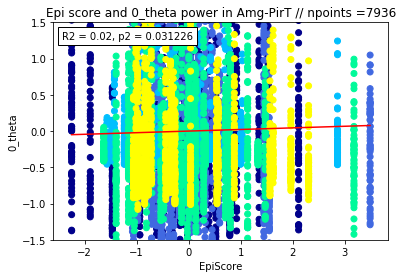

In [44]:
from mne.stats import bonferroni_correction, fdr_correction
import pandas as pd

score = 'Rec' #'Epi'
feat, corr, win, th, phase = 'pow', False, 1.0, '0.01','Retrieval'
###############################################################################
st = study('Olfacto')
path_npz = join(st.path, 'feature/0_Power_Retrieval_By_Odor/')
npz_form = join(path_npz, '{}_odor_{}_bipo_sel_physFT_pow.npz')
path_classif = join(st.path, 'figure/0_Classif_Power_'+phase[0]+'_EpiPerf_LowHigh_1000perm_BBG/')
#path_classif = join(st.path, 'figure/LDA_Power_R_pre_stim_1s_BBG/')
#path_npz = join(st.path, 'feature/TPSim_Enc_Ret_By_Odor_all/TPS_R_p_by_odor/')
#npz_form = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
#path_classif = join(st.path, 'figure/LDA_TPSim_E_R_all_BBG/')
classif_npz = join(path_classif, '{}_sources_{}_{}_low_high_sel_physFT.npz')
masks_form = join(path_classif, 'masks_stat/All_subjects_mask_stat_{}_minwin{}_th{}.npy') 
path2save = join(st.path, 'correlations_pow_all_trials/'+phase+'/TR_'+score.lower()+'/')
f_form_save = join(path2save, 'Correl_{}_{}_{}_{}_first.png')
f_form_save2 = join(path2save, 'Correl_{}_{}_{}_{}_first.pdf')
path_TR = '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/1bis_OE_BaseSam/JPlailly201306_seeg_ALS/behavior/'
###############################################################################
freqs = ['0_theta','1_alpha','2_beta','3_gamma']
method = ['label']
###############################################################################
sub_list = ['VACJ','SEMC','PIRJ','FERJ','LEFC','CHAF','MICP'] if phase == 'Encoding' else ['VACJ','SEMC','PIRJ','FERJ','LEFC','CHAF']
odors_su = {'VACJ': [16, 17, 10, 11, 12, 13, 14, 15],
            'SEMC': [5, 7, 8, 9, 10, 11, 12, 13],
            'PIRJ': [1, 18, 4, 5, 6, 7, 9],
            'FERJ': [16, 1, 2, 17, 5, 7, 12, 13],
            'LEFC': [16, 1, 2, 3, 4, 17, 14, 15], 
            'CHAF': [1, 2, 3, 4, 5, 7, 8, 9],
            'MICP': []}

u_color = ["darkblue", "royalblue", "deepskyblue", "mediumspringgreen", "yellow", "darkorange","red"]
rois_to_keep = ['ACC','Amg','Amg-PirT','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']

pvals, pvals2, R_all, R2_all, rois_all, freqs_all = [], [], [], [], [], []
for i,freq in enumerate(freqs):
    mat = np.load(classif_npz.format('All_subjects',freq, 'odor'))
    id_rois = np.where([roi in rois_to_keep for roi in mat['s_labels']])
    subjects = mat['su_codes'][id_rois]
    mask = np.load(masks_form.format(freq,str(win),th))
    mask = np.logical_not(mask) #inverse of visbrain 
    for roi in sorted(rois_to_keep):
        pow_odors, scores_odors, su_list = [], [], []
        if roi == 'pPirT':
            continue
        for s,su in enumerate(sorted(sub_list)):
            df_TR = pd.read_excel(path_TR+'episodic_individual_results_.xls', sheetname=su)
            if phase == 'Encoding' and su =='MICP':
                print('pass',su)
            else:
                mask_su = mask[np.where(subjects=='S'+str(s))]
                pow_su, score_su = [], []
                for odor in odors_su[su]:
                    arch_sig = np.load(npz_form.format(su,odor,freq))
                    #print(arch_sig.files)
                    id_roi_su = np.where([roi in rois_to_keep for roi in arch_sig['Mai_RL']])
                    Mai_RL= arch_sig['Mai_RL'][id_roi_su][mask_su] #'Mai_RL','label'
                    power = arch_sig['xpow'][i,:,:,:][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                    #power = np.mean(arch_sig['xpow'][i,:,27:47,:],axis=(1))[id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                    #power = arch_sig['tps'][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                    if roi == 'Amg-PirT' and power.size:
                        power_roi = power[np.where(roi in ['pPirT','Amg-PirT'] for roi in Mai_RL)]
                    else:
                        power_roi = power[np.where(Mai_RL==roi)]
                    #print('power shape', power_roi.shape)
                    power_roi = np.ndarray.flatten(power_roi)
                    df_od = df_TR.loc[df_TR['odor_num']==odor]                    
                    col = 'odor_recognition_rt' if score == 'Rec' else 'episodic_rt'
                    score_roi = [df_od[col].values]*int(power_roi.shape[0]/4) if su == 'PIRJ' else [df_od[col].values]*int(power_roi.shape[0]/3)
                    score_roi = np.ndarray.flatten(np.asarray(score_roi))
                    su_codes = ['S'+str(s)]*power_roi.shape[0]
                    #print(su,odor,freq,power_roi.shape,score_roi.shape)
                    pow_su = np.append(pow_su,power_roi)
                    score_su = np.append(score_su,score_roi)
                    su_list = np.append(su_list,su_codes)
                pow_su = (pow_su - pow_su.mean())/pow_su.std()
                score_su = (score_su - score_su.mean())/score_su.std()
                pow_odors = np.append(pow_odors,pow_su)
                scores_odors = np.append(scores_odors,score_su)
                #print(su,pow_odors.shape,scores_odors.shape,su_list.shape)
        scores_odors = np.array(scores_odors)[np.where(~np.isnan(pow_odors))]
        pow_odors = np.array(pow_odors)[np.logical_not(np.isnan(pow_odors))]
        pow_odors = np.array(pow_odors)[np.where(~np.isnan(scores_odors))]
        scores_odors = np.array(scores_odors)[np.logical_not(np.isnan(scores_odors))]
        #Plot all correlations
        R, p = stats.pearsonr(scores_odors,pow_odors)
        R2, p2 = stats.spearmanr(scores_odors,pow_odors)
        R, p = round(R,2), round(p,7)
        R2, p2 = round(R2,2), round(p2,7)
        pvals, pvals2 = np.append(pvals,p), np.append(pvals2,p2)
        R_all = np.append(R_all, R)
        R2_all = np.append(R2_all, R2)
        print('stats for',freq,roi,R2,p2,scores_odors.shape,pow_odors.shape)
        rois_all.append(roi)
        freqs_all.append(freq)
        color = [u_color[int(k[1])] for k in sorted(su_list)]
        if p2 < 0.05:
            fig, ax = plt.subplots()
            plt.title('Epi score and '+freq+' power in '+roi+' // npoints ='+str(len(scores_odors)))
            plt.xlabel('EpiScore'), plt.ylabel(freq)
            plt.ylim(-1.5,1.5)
            anchored_text = AnchoredText('R2 = %s, p2 = %s' % (R2, p2), loc=2)
            ax.add_artist(anchored_text)
            fit = np.polyfit(scores_odors, pow_odors, deg=1)
            ax.plot(sorted(scores_odors), fit[0] * np.array(sorted(scores_odors)) + fit[1], color='red')
            ax.scatter(scores_odors, pow_odors, color = color)
            plt.savefig(f_form_save.format(freq,roi,'EpiScore_win1','z-score'))
            plt.savefig(f_form_save2.format(freq,roi,'EpiScore_win1','z-score'))
            plt.clf()
            plt.close()
pvals = np.array(pvals)[np.logical_not(np.isnan(pvals))]
R2_all = np.array(R2_all)[np.logical_not(np.isnan(pvals2))]
rois_all = np.array(rois_all)[np.logical_not(np.isnan(pvals2))]
freqs_all = np.array(freqs_all)[np.logical_not(np.isnan(pvals2))]
pvals2 = np.array(pvals2)[np.logical_not(np.isnan(pvals2))]

## Determine the threshold p value for FDR correction
print(sorted(rois_to_keep))
print('Spearman results')
print('R coef',R2_all)
_, pval_fdr2 = fdr_correction(pvals2, alpha=0.01, method='indep')

for i,s in enumerate(pval_fdr2):
    if s < 0.05 :
        print('FDR','freq',freqs_all[i],rois_all[i],'R',R2_all[i],'p',round(s,5))
        

### Correlations btw TR and richness by odor

In [ ]:
phases = ['Rec','Epi','diff']
scores_od = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #15:4 remove for TPS
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}
TR_od_phase = {'Rec':{'LEFC': {16: 4.68, 1: 3.94, 2: 8.43, 3: 6.05, 4: 4.74, 17: 5.52, 14: 4.03, 15: 5.01}, 
                      'SEMC': {5: 9.1, 7: 6.08, 8: 9.11, 9: 6.62, 10: 7.76, 11: 8.53, 12: 9.99, 13: 4.17}, 
                      'PIRJ': {1: 4.48, 18: 5.89, 4: 5.75, 5: 7.43, 6: 5.11, 7: 3.14, 9: 5.79}, 
                      'FERJ': {16: 5.0, 1: 2.28, 2: 4.14, 17: 4.12, 5: 3.08, 7: 2.8, 12: 3.11, 13: 3.53}, 
                      'CHAF': {1: 3.21, 2: 6.7, 3: 4.89, 4: 4.34, 5: 5.84, 7: 4.67, 8: 4.45, 9: 5.94}, 
                      'VACJ': {16: 5.86, 17: 10.84, 10: 7.37, 11: 10.04, 12: 10.65, 13: 4.56, 14: 9.16, 15: 6.45}}, 
               
               'Epi':{'LEFC': {16: 4.92, 1: 6.82, 3: 8.02, 4: 8.41, 17: 6.79, 14: 5.35, 15: 12.41}, 
                      'SEMC': {5: 10.05, 7: 6.35, 8: 10.26, 9: 7.83, 10: 8.51, 11: 13.0, 12: 9.93, 13: 5.48}, 
                      'PIRJ': {1: 4.81, 18: 8.11, 4: 9.33, 5: 9.83, 6: 10.57, 7: 4.98, 9: 7.54}, 
                      'FERJ': {16: 7.96, 1: 4.42, 2: 5.89, 17: 6.3, 5: 4.84, 7: 5.23, 12: 4.33, 13: 7.07}, 
                      'CHAF': {1: 4.39, 2: 9.27, 3: 6.42, 4: 6.26, 5: 7.96, 7: 5.82, 8: 6.08, 9: 7.77}, 
                      'VACJ': {16: 8.25, 17: 15.96, 10: 14.97, 11: 14.79, 12: 25.83, 13: 10.68, 14: 16.55, 15: 6.1}},
               
               'diff':{'LEFC': {16: 0.91, 1: 0.96, 3: 1.98, 4: 3.67, 17: 1.26, 14: 1.32, 15: 8.25}, 
                       'SEMC': {5: 0.94, 7: 1.3, 8: 1.15, 9: 1.21, 10: 0.94, 11: 1.68, 12: 1.8, 13: 1.31},
                       'PIRJ': {1: 1.15, 18: 1.85, 4: 3.61, 5: 3.78, 6: 5.78, 7: 2.69, 9: 3.12},
                       'FERJ': {16: 2.16, 1: 2.14, 2: 2.51, 17: 2.28, 5: 1.76, 7: 2.43, 12: 1.73, 13: 3.54}, 
                       'CHAF': {1: 1.18, 2: 1.71, 3: 1.53, 4: 1.92, 5: 2.12, 7: 1.16, 8: 1.63, 9: 1.84}, 
                       'VACJ': {16: 2.39, 17: 7.42, 10: 7.6, 11: 3.87, 12: 15.17, 13: 6.12, 14: 7.38, 15: 2.46}}}

R_all, pvals = [], []
for phase in TR_od_phase:
    score, RT = np.array([]), np.array([])
    for su in TR_od_phase[phase]:
        score_su, RT_su = [], []
        for odor in TR_od_phase[phase][su]:
            score_su.append(scores_od[su][odor])
            RT_su.append(TR_od_phase[phase][su][odor])
        score_su = (score_su - np.mean(score_su))/np.std(score_su)
        RT_su = (RT_su - np.mean(RT_su))/np.std(RT_su)
        score = np.hstack((score,score_su)) if np.size(score) else score_su
        RT = np.hstack((RT,RT_su)) if np.size(RT) else RT_su
    R2, p2 = stats.spearmanr(score,RT)
    R2, p2 = round(R2,2), round(p2,7)
    print(phase, R2, p2)
    pvals, R_all = np.append(pvals,p2), np.append(R_all,R2)
    fig, ax = plt.subplots()
    plt.title('Epi score and RT for '+phase+' // npoints ='+str(len(score)))
    plt.xlabel('EpiScore'), plt.ylabel('RT(s)')
#         plt.ylim(-2,3)
    anchored_text = AnchoredText('R2 = %s, p2 = %s' % (R2, p2), loc=2)
    ax.add_artist(anchored_text)
    fit = np.polyfit(score, RT, deg=1)
    ax.plot(sorted(score), fit[0] * np.array(sorted(score)) + fit[1], color='red')
    ax.scatter(score, RT)
    plt.show()

print('Spearman results')
print('R coef',R_all)
_, pval_fdr = fdr_correction(pvals, alpha=0.01, method='indep')
print(pval_fdr)
            
            

### Correlation of theta power in OFC in pre and post-stim

In [50]:
from mne.stats import bonferroni_correction, fdr_correction

feat, corr, win, th, alpha = 'pow', False, 1.0, '0.01',0.05
phase0, phase1 = 'R_pre_stim_1s','Retrieval'

###############################################################################
st = study('Olfacto')
path_classif = join(st.path, 'figure/LDA_Power_R_pre_stim_1s_BBG/')
classif_npz = join(path_classif, '{}_sources_{}_{}_low_high_sel_physFT.npz')
path_npz0 = join(st.path, 'feature/0_Power_'+phase0+'/')
path_npz1 = join(st.path, 'feature/0_Power_'+phase1+'_EpiPerf_LowHigh/')
npz_form0 = join(path_npz0, '{}_odor_{}_bipo_sel_physFT_pow.npz')
npz_form1 = join(path_npz1, '{}_odor_{}_bipo_sel_physFT_pow.npz')
masks_form = join(path_classif, 'masks_stat/All_subjects_mask_stat_{}_minwin{}_th{}.npy') 
path2save = join(st.path, 'correlations_pow_all_trials/'+phase0+'/')
f_form_save = join(path2save, 'Correl_{}_{}_{}_{}.png')
###############################################################################
subj = ['CHAF','LEFC','PIRJ','FERJ','SEMC','VACJ']
freq = '0_theta'
method = ['s_Mail_RL']
###############################################################################

u_color = ["darkblue", "royalblue", "deepskyblue", "mediumspringgreen", "yellow", "darkorange","red"]
rois_to_keep = ['ACC','Amg','Amg-PirT','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']

mat = np.load(classif_npz.format('All_subjects',freq, 'odor'))
id_rois = np.where([roi in rois_to_keep for roi in mat['s_labels']])
subjects = mat['su_codes'][id_rois]
mask = np.load(masks_form.format(freq,str(win),th))
mask = np.logical_not(mask) #inverse of visbrain 

H_L_diff_su_pre, H_L_diff_su_post = np.array([]), np.array([])
H_L_diff_su_pre_norm, H_L_diff_su_post_norm = np.array([]), np.array([])
su_list = np.array([])
for s,su in enumerate(sorted(subj)):
    mask_su = mask[np.where(subjects=='S'+str(s))]
    #load power for pre-stim
    pre_high = np.load(npz_form0.format(su,'high'))               
    id_roi_su = np.where([roi in rois_to_keep for roi in pre_high['Mai_RL']])
    Mai_RL= pre_high['Mai_RL'][id_roi_su][mask_su]
    pow_pre_H = pre_high['xpow'][0,:,:][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
    pow_pre_H = pow_pre_H[np.where(Mai_RL=='OFC')]
    pre_low = np.load(npz_form0.format(su,'low'))               
    pow_pre_L = pre_low['xpow'][0,:,:][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
    pow_pre_L = pow_pre_L[np.where(Mai_RL=='OFC')]
       
    #load power for post-stim
    pow_post_H = np.mean(np.load(npz_form1.format(su,'high'))['xpow'][0,:,27:47,:],axis=(1))[id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
    pow_post_L = np.mean(np.load(npz_form1.format(su,'low'))['xpow'][0,:,27:47,:],axis=(1))[id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
    pow_post_H = pow_post_H[np.where(Mai_RL=='OFC')]
    pow_post_L = pow_post_L[np.where(Mai_RL=='OFC')]
    
    #compute High-Low differences
    if pow_pre_H.shape[0]>0:
        print(su,pow_post_L.shape)
#         pow_pre_H = np.ndarray.flatten(np.mean(pow_pre_H,axis=0)[np.newaxis])
#         pow_pre_L = np.ndarray.flatten(np.mean(pow_pre_L,axis=0)[np.newaxis])
#         pow_post_H = np.ndarray.flatten(np.mean(pow_post_H,axis=0)[np.newaxis])
#         pow_post_L = np.ndarray.flatten(np.mean(pow_post_L,axis=0)[np.newaxis])
        pow_pre_H = np.ndarray.flatten(pow_pre_H)
        pow_pre_L = np.ndarray.flatten(pow_pre_L)
        pow_post_H = np.ndarray.flatten(pow_post_H)
        pow_post_L = np.ndarray.flatten(pow_post_L)
        print(su,pow_post_L.shape)
        
        H_L_diff = np.array([])
        for H, L in product(pow_pre_H,pow_pre_L):
            diff = (H-L)/L
            H_L_diff = np.hstack((H_L_diff,diff)) if np.size(H_L_diff) else diff
        H_L_diff_su_pre = np.hstack((H_L_diff_su_pre,H_L_diff)) if np.size(H_L_diff_su_pre) else H_L_diff
        diff_norm = (H_L_diff - np.mean(H_L_diff))/np.std(H_L_diff)
        H_L_diff_su_pre_norm = np.hstack((H_L_diff_su_pre_norm,diff_norm)) if np.size(H_L_diff_su_pre_norm) else diff_norm
        
        H_L_diff2 = np.array([])
        for H, L in product(pow_post_H, pow_post_L):
            diff = (H-L)/L
            H_L_diff2 = np.hstack((H_L_diff2,diff)) if np.size(H_L_diff2) else diff
        H_L_diff_su_post = np.hstack((H_L_diff_su_post,H_L_diff2)) if np.size(H_L_diff_su_post) else H_L_diff2
        diff_norm = (H_L_diff2 - np.mean(H_L_diff2))/np.std(H_L_diff2)
        H_L_diff_su_post_norm = np.hstack((H_L_diff_su_post_norm,diff_norm)) if np.size(H_L_diff_su_post_norm) else diff_norm
        
        su_code = ['S'+str(s)]*H_L_diff2.shape[0]
        su_list = np.hstack((su_list,su_code)) if np.size(su_list) else su_code

#Plot all correlations not norm
R2, p2 = stats.spearmanr(H_L_diff_su_pre,H_L_diff_su_post)
color = [u_color[int(k[1])] for k in sorted(su_list)]
fig, ax = plt.subplots(figsize=(5,10))
plt.title('Pow pre and post stim \n for '+freq+' in OFC // npoints ='+str(len(H_L_diff_su_pre)))
plt.xlabel('pow_pre'), plt.ylabel('pow_post')
anchored_text = AnchoredText('R2 = %s, p2 = %s' % (round(R2,2), p2), loc=2)
ax.add_artist(anchored_text)
fit = np.polyfit(H_L_diff_su_pre, H_L_diff_su_post, deg=1)
ax.plot(H_L_diff_su_pre, fit[0] * H_L_diff_su_pre + fit[1], color='red')
ax.scatter(H_L_diff_su_pre[:], H_L_diff_su_post[:], color = color)
plt.savefig(f_form_save.format(freq,'OFC','all_no_norm','su'))
plt.clf()
plt.close()

#Plot all correlations NORM
R2, p2 = stats.spearmanr(H_L_diff_su_pre_norm,H_L_diff_su_post_norm)
color = [u_color[int(k[1])] for k in sorted(su_list)]
fig, ax = plt.subplots(figsize=(5,10))
plt.title('NORM Pow pre and post stim \n for '+freq+' in OFC // npoints ='+str(len(H_L_diff_su_pre)))
plt.xlabel('pow_pre'), plt.ylabel('pow_post')
anchored_text = AnchoredText('R2 = %s, p2 = %s' % (round(R2,2), p2), loc=2)
ax.add_artist(anchored_text)
fit = np.polyfit(H_L_diff_su_pre_norm, H_L_diff_su_post_norm, deg=1)
ax.plot(H_L_diff_su_pre_norm, fit[0] * H_L_diff_su_pre_norm + fit[1], color='red')
ax.scatter(H_L_diff_su_pre_norm[:], H_L_diff_su_post_norm[:], color = color)
plt.savefig(f_form_save.format(freq,'OFC','all_norm','su'))
plt.clf()
plt.close()


-> Olfacto loaded
PIRJ (2, 16)
PIRJ (32,)
SEMC (1, 15)
SEMC (15,)
VACJ (1, 12)
VACJ (12,)


### Correlations btw TPSim and Power for signif elecs

In [4]:
from mne.stats import bonferroni_correction, fdr_correction
from scipy import stats

feat, corr, phase, win,th, alpha = 'tps', False, 'Retrieval', 1.0,'0.01',0.05
groups = 4
###############################################################################
st = study('Olfacto')
###############################################################################
path_classif = join(st.path, 'figure/LDA_TPSim_E_R_all_BBG/')
classif_npz = join(path_classif, '{}_sources_{}_{}_low_high_sel_physFT.npz')
masks_form = join(path_classif, 'masks_stat/All_subjects_mask_stat_{}_minwin{}_th{}.npy') 
path_npz = join(st.path, 'feature/TPSim_Enc_Ret_By_Odor_all/TPS_R_p_by_odor/')
path2save = join(st.path, 'kruskal_TPSim_all_trials/Correl_TPSim_signif'+str(groups)+'/')
npz_form = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
f_form_save = join(path2save, 'Correl_{}_{}_{}.pdf')
f_form_save2 = join(path2save, 'Correl_{}_{}_{}.png')
###############################################################################
if not exists(path2save):
    makedirs(path2save)
###############################################################################

su_codes = [['S0','S1','S2','S3','S4','S5','S6'] if phase == 'Encoding' 
            else ['S0','S1','S2','S3','S4','S5']]
#freqs = ['2_theta', '3_alpha', '4_beta','5_gamma1','6_gamma2']
freqs = ['0_theta', '1_alpha', '2_beta','3_gamma']
method = ['s_Mail_RL']

if phase == 'Encoding':
    odors_su = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'MICP': {2:6,12:8,6:96,8:8,3:12,18:4,9:6,14:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}
else:
    odors_su = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68},#15:4 #remove for TPSim 15:4
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}}
rois_to_keep = ['ACC','Amg','Amg-PirT','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']
rois = ['ACC','Amg','HC','IFG','Ins','MFG','OFC','PHG',
                'SFG','pPirT']

pvals, R_vals, r_vals = [], [], []
for i,freq in enumerate(freqs):
    #Load all data classif 
    mat = np.load(classif_npz.format('All_subjects',freq, 'odor'))
    #Filter matrix for MTl, Olf and Frontal regions
    id_rois = np.where([roi in rois_to_keep for roi in mat['s_labels']])
    subjects = mat['su_codes'][id_rois]
    #Load mask for significant elecs
    mask = np.load(masks_form.format(freq,str(win),th))
    mask = np.logical_not(mask) #transform inverse of visbrain 
    
    #Correlation by freq and by region for all subjects
    for region in sorted(rois):
        pow_odors,pow_raw, scores_odors, su_list = [], [], [],[]
        for s,su in enumerate(sorted(odors_su)):
            mask_su = mask[np.where(subjects=='S'+str(s))]
            pow_su, score_su = [], []
            for odor in odors_su[su]:
                arch_sig = np.load(npz_form.format(su,odor,freq))
                #Take only SIGNIF electrodes in MTL, Olf, Frontal
                id_roi_su = np.where([roi in rois_to_keep for roi in arch_sig['label']])
                Mai_RL= arch_sig['label'][id_roi_su][mask_su]
#                 power = np.mean(arch_sig['xpow'][i,:,27:47,:],axis=(1))[id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                power = arch_sig['tps'][id_roi_su][mask_su] #nfreq,nelecs,npts,ntrials
                if region == 'pPirT':
                    power_roi = power[np.where(roi in ['pPirT','Amg-PirT'] for roi in Mai_RL)]
                else:
                    power_roi = power[np.where(Mai_RL==region)]
                power_roi = np.ndarray.flatten(power_roi)
                score_roi = [odors_su[su][odor]]*power_roi.shape[0]
                pow_su = np.append(pow_su,power_roi)
                score_su = np.append(score_su,score_roi)
            pow_su_norm = (pow_su - pow_su.mean())/pow_su.std()
            score_su_norm = (score_su - score_su.mean())/score_su.std()
            pow_odors = np.append(pow_odors,pow_su_norm)
            scores_odors = np.append(scores_odors,score_su_norm)
            pow_raw = np.append(pow_raw,pow_su)
            
        R2, p2 = stats.spearmanr(scores_odors,pow_odors)
        R2, p2 = round(R2,2), round(p2,7)
        pvals = np.append(pvals, p2)
        R_vals = np.append(R_vals, R2)
        r_vals = np.append(r_vals, region)
        color = [u_color[int(k[1])] for k in sorted(su_list)]
        fig, ax = plt.subplots()
        plt.title('Epi score and '+freq+' power in '+region+' // npoints ='+str(len(scores_odors)))
        plt.xlabel('EpiScore'), plt.ylabel(freq)
        plt.ylim(-1.5,1.5)
        anchored_text = AnchoredText('R2 = %s, p2 = %s' % (R2, p2), loc=2)
        ax.add_artist(anchored_text)
        fit = np.polyfit(scores_odors, pow_odors, deg=1)
        ax.plot(sorted(scores_odors), fit[0] * np.array(sorted(scores_odors)) + fit[1], color='red')
        ax.scatter(scores_odors, pow_odors, color = color)
        plt.savefig(f_form_save.format(freq,region,'EpiScore_win1','z-score'))
        plt.savefig(f_form_save2.format(freq,region,'EpiScore_win1','z-score'))
        plt.clf()
        plt.close()
print(r_vals)
pvals = np.array(pvals)[r_vals=='HC']
H_vals = np.array(H_vals)[r_vals=='HC']
#pvals = np.array(pvals)[np.logical_not(np.isnan(pvals))]
## Determine the threshold p value for FDR correction
_, pval_bonf = bonferroni_correction(pvals, alpha=alpha)
#print(np.round(pval_bonf,3))

_, pval_fdr = fdr_correction(pvals, alpha=alpha, method='indep')
print(np.round(pval_fdr,3))
print(pval_fdr)
print('H values', np.round(H_vals,2))


-> Olfacto loaded


/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice.
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/karim/anaconda3/envs/mne_coreg/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of e

['ACC' 'Amg' 'HC' 'IFG' 'Ins' 'MFG' 'OFC' 'PHG' 'SFG' 'pPirT' 'ACC' 'Amg'
 'HC' 'IFG' 'Ins' 'MFG' 'OFC' 'PHG' 'SFG' 'pPirT' 'ACC' 'Amg' 'HC' 'IFG'
 'Ins' 'MFG' 'OFC' 'PHG' 'SFG' 'pPirT' 'ACC' 'Amg' 'HC' 'IFG' 'Ins' 'MFG'
 'OFC' 'PHG' 'SFG' 'pPirT']


NameError: name 'H_vals' is not defined